<a href="https://colab.research.google.com/github/MicheleGiambelli/Deep-Learning-Project/blob/Michele/Crypto_guru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [317]:
import pandas as pd
import numpy as np
import yfinance as yf
from google.colab import files

import math
import scipy.stats as stats
from scipy.stats import shapiro, pearsonr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt


from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Preparazione dataset

In [318]:
ticker = "SOL-USD"
btc_ticker = "BTC-USD"

solana_data = yf.download(ticker, start="2020-04-10")
btc_data = yf.download(btc_ticker, start="2020-04-10")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [319]:
# Ensure the columns are renamed every time this cell is run
solana_data = solana_data.rename(columns={"Adj Close": "SOL_Adj_Close"})
btc_data = btc_data.rename(columns={"Adj Close": "BTC_Adj_Close"})

# Unione dei dati
# Instead of selecting individual columns, use the renamed dataframes directly
df = pd.concat([solana_data, btc_data], axis=1)
df = df.dropna()

# Calcolo dei rendimenti giornalieri
df["SOL_Return"] = df["SOL_Adj_Close"].pct_change()
df["BTC_Return"] = df["BTC_Adj_Close"].pct_change()

# Funzione per calcolare Beta
def rolling_beta(df, window):
    cov = df["SOL_Return"].rolling(window).cov(df["BTC_Return"])
    var = df["BTC_Return"].rolling(window).var()
    return cov / var

# Define n before using it in rolling_beta
n = 20  # For example, a 20-day rolling window for beta calculation

# Aggiungere Beta
df["Beta"] = rolling_beta(df, n)
df = df.dropna()


In [320]:
n = 20  # Periodo per bande di Bollinger e Beta
k = 2  # Deviazioni standard per bande di Bollinger

# Calcolo Bande di Bollinger
df["SMA"] = df["SOL_Adj_Close"].rolling(window=n).mean()
df["StdDev"] = df["SOL_Adj_Close"].rolling(window=n).std()
df["Upper_Band"] = df["SMA"] + k * df["StdDev"]
df["Lower_Band"] = df["SMA"] - k * df["StdDev"]
df = df.dropna()


In [321]:
def rolling_sharpe_ratio(df, window, risk_free_rate):
    rolling_mean = df["SOL_Return"].rolling(window).mean()
    rolling_std = df["SOL_Return"].rolling(window).std()
    return (rolling_mean - risk_free_rate) / rolling_std
risk_free_rate = 0.01
# Aggiungere Sharpe Ratio
df["Sharpe_Ratio"] = rolling_sharpe_ratio(df, n, risk_free_rate)
df = df.dropna()


In [322]:
df.drop(df.columns[[6,7,8,9,10,11,13]], axis=1, inplace=True) # tolgo le colonne relative a BTC che non mi servono
df.head()

Price,SOL_Adj_Close,Close,High,Low,Open,Volume,SOL_Return,Beta,SMA,StdDev,Upper_Band,Lower_Band,Sharpe_Ratio
Ticker,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD,,,,,,,
Date,,,,,,,,,,,,,
2020-06-07,0.616578,0.616578,0.624444,0.593398,0.622443,716785,-0.009423,0.427358,0.595371,0.027581,0.650533,0.540209,-0.201951
2020-06-08,0.668313,0.668313,0.679001,0.613310,0.615078,1440234,0.083907,0.428930,0.597564,0.031483,0.660529,0.534599,-0.085599
2020-06-09,0.658002,0.658002,0.668088,0.627242,0.667784,988327,-0.015428,0.346123,0.601506,0.033900,0.669306,0.533706,-0.038440
2020-06-10,0.644867,0.644867,0.670043,0.633404,0.658038,1096203,-0.019962,0.524364,0.603304,0.035240,0.673784,0.532823,-0.103663
2020-06-11,0.573742,0.573742,0.650535,0.570082,0.644888,1122221,-0.110294,0.739265,0.600047,0.034787,0.669620,0.530474,-0.229623


In [323]:
df.tail()

Price,SOL_Adj_Close,Close,High,Low,Open,Volume,SOL_Return,Beta,SMA,StdDev,Upper_Band,Lower_Band,Sharpe_Ratio
Ticker,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD,,,,,,,
Date,,,,,,,,,,,,,
2024-12-03,234.200317,234.200317,239.272522,216.473022,225.768570,8404095315,0.037404,1.134428,236.977356,12.988001,262.953359,211.001353,-0.115827
2024-12-04,229.119293,229.119293,240.719589,225.254913,234.200317,6569129896,-0.021695,1.066410,237.972367,11.416749,260.805866,215.138868,-0.109308
2024-12-05,233.998703,233.998703,244.680954,223.460541,229.119385,8820663279,0.021296,0.955565,238.767557,10.474358,259.716273,217.818841,-0.136633
2024-12-06,237.051071,237.051071,246.418655,231.425964,236.541473,6726557034,0.013044,0.889403,239.827669,9.002143,257.831954,221.823383,-0.108802
2024-12-07,238.493057,238.493057,239.282486,234.717743,237.076462,4801945088,0.006083,1.020490,239.873545,8.992394,257.858333,221.888757,-0.264886


# DEA

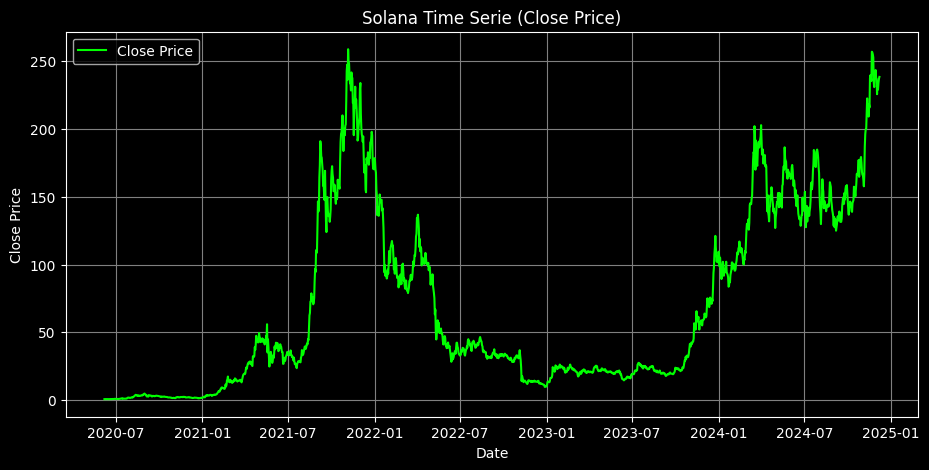

In [324]:
# Grafico dell'andamento storico del titolo
plt.figure(figsize=(11, 5))
plt.style.use('dark_background')
plt.plot(df.index, df[('Close', 'SOL-USD')], label='Close Price', color='lime')
plt.title('Solana Time Serie (Close Price)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(color='gray')
plt.show()


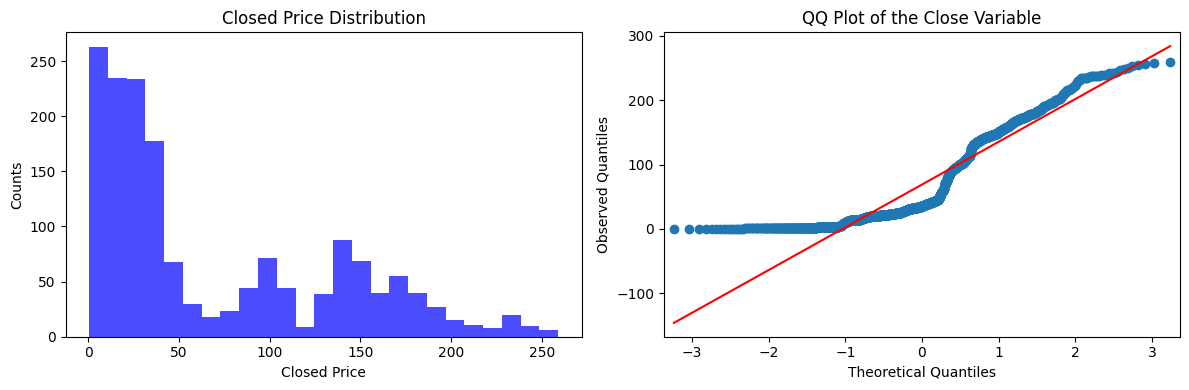

In [325]:
plt.style.use('default')

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Histogram plot
axs[0].hist(df[('Close', 'SOL-USD')], bins=25, color='blue', alpha=0.7)
axs[0].set_xlabel('Closed Price')
axs[0].set_ylabel('Counts')
axs[0].set_title('Closed Price Distribution')

# QQ plot
sm.qqplot(df[('Close', 'SOL-USD')], line='s', ax=axs[1])
axs[1].set_title('QQ Plot of the Close Variable')
axs[1].set_xlabel('Theoretical Quantiles')
axs[1].set_ylabel('Observed Quantiles')

plt.tight_layout()
plt.show()

Skewed distribution, distribuzione più adatte :
Lognormale:
La distribuzione lognormale è un candidato probabile per dati con skewness positiva e strettamente positivi.
Viene utilizzata per modellare grandezze che crescono moltiplicativamente, come prezzi, redditi o tempi di attesa.
Gamma:
Anche la distribuzione Gamma è adatta per dati positivi e skewed positivamente.
È più flessibile della lognormale e potrebbe modellare i dati meglio se ci sono picchi o variazioni particolari.




 --> usiamo minMaxScaler o RobustScaler e non StandardScaler.



In [326]:
# Calcolare lo Shapiro-Wilk test sulla variabile 'close'
stat, p_value = shapiro(df['Close'])

print(f"Shapiro-Wilk Test Statistic: {stat:.4f}")
print(f"P-Value: {p_value:.4f}")
if p_value > 0.05:
    print("La distribuzione dei dati è probabilmente normale (non rifiutiamo H0).")
else:
    print("La distribuzione dei dati non è normale (rifiutiamo H0).")

Shapiro-Wilk Test Statistic: 0.8543
P-Value: 0.0000
La distribuzione dei dati non è normale (rifiutiamo H0).


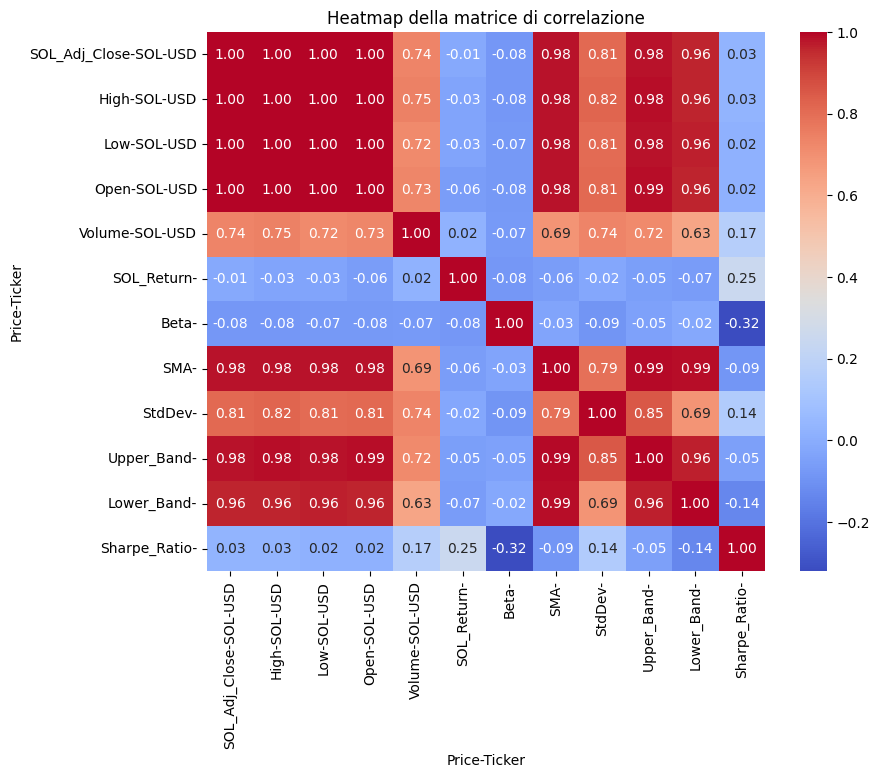

Variance Inflation Factor (VIF):
                    Variable          VIF
7                    (SMA, )          inf
8                 (StdDev, )          inf
9             (Upper_Band, )          inf
10            (Lower_Band, )          inf
1            (High, SOL-USD)  1738.006868
0   (SOL_Adj_Close, SOL-USD)  1173.523802
3            (Open, SOL-USD)  1031.305021
2             (Low, SOL-USD)   944.856960
4          (Volume, SOL-USD)     4.457710
11          (Sharpe_Ratio, )     1.830466
5             (SOL_Return, )     1.739185
6                   (Beta, )     1.163321


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [327]:
# Rimozione dei valori NaN per analisi pulita
df_sol_clean = df.dropna()

# Gestione del MultiIndex: rimuovi la variabile target specificando entrambi i livelli
target_var = ('Close', 'SOL-USD')  # Nome esatto della variabile nel MultiIndex
independent_vars = [col for col in df_sol_clean.columns if col != target_var]

# Matrice di correlazione
correlation_matrix = df_sol_clean[independent_vars].corr()

# Visualizzazione della matrice di correlazione
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap della matrice di correlazione")
plt.show()

# Calcolo del VIF
X = df_sol_clean[independent_vars]
X_with_const = sm.add_constant(X)  # Aggiungi la costante per il calcolo del VIF

vif_data = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X_with_const.values, i + 1) for i in range(X.shape[1])]
}).sort_values(by="VIF", ascending=False)

# Mostra i risultati del VIF
print("Variance Inflation Factor (VIF):")
print(vif_data)

# Suggerimento: Rimuovi o combina variabili con VIF molto elevato.


**Indago la linearità**

Nel secondo grafico ho messo solo le variabili che secondo me ha senso includere nella regressione, ho tolto:
-Lower/Upper band, più che altro perché dipendono strettamente dalla media mobile (SMA) e quindi non ha senso metterle se già c’è SMA altrimenti avrebbero una collinearità molto alta.
-prezzo di apertura (open) perché è come se utilizzassimo close 2 volte per titolo (il prezzo di apertura del giorno dopo è quello di chiusura del giorno prima).

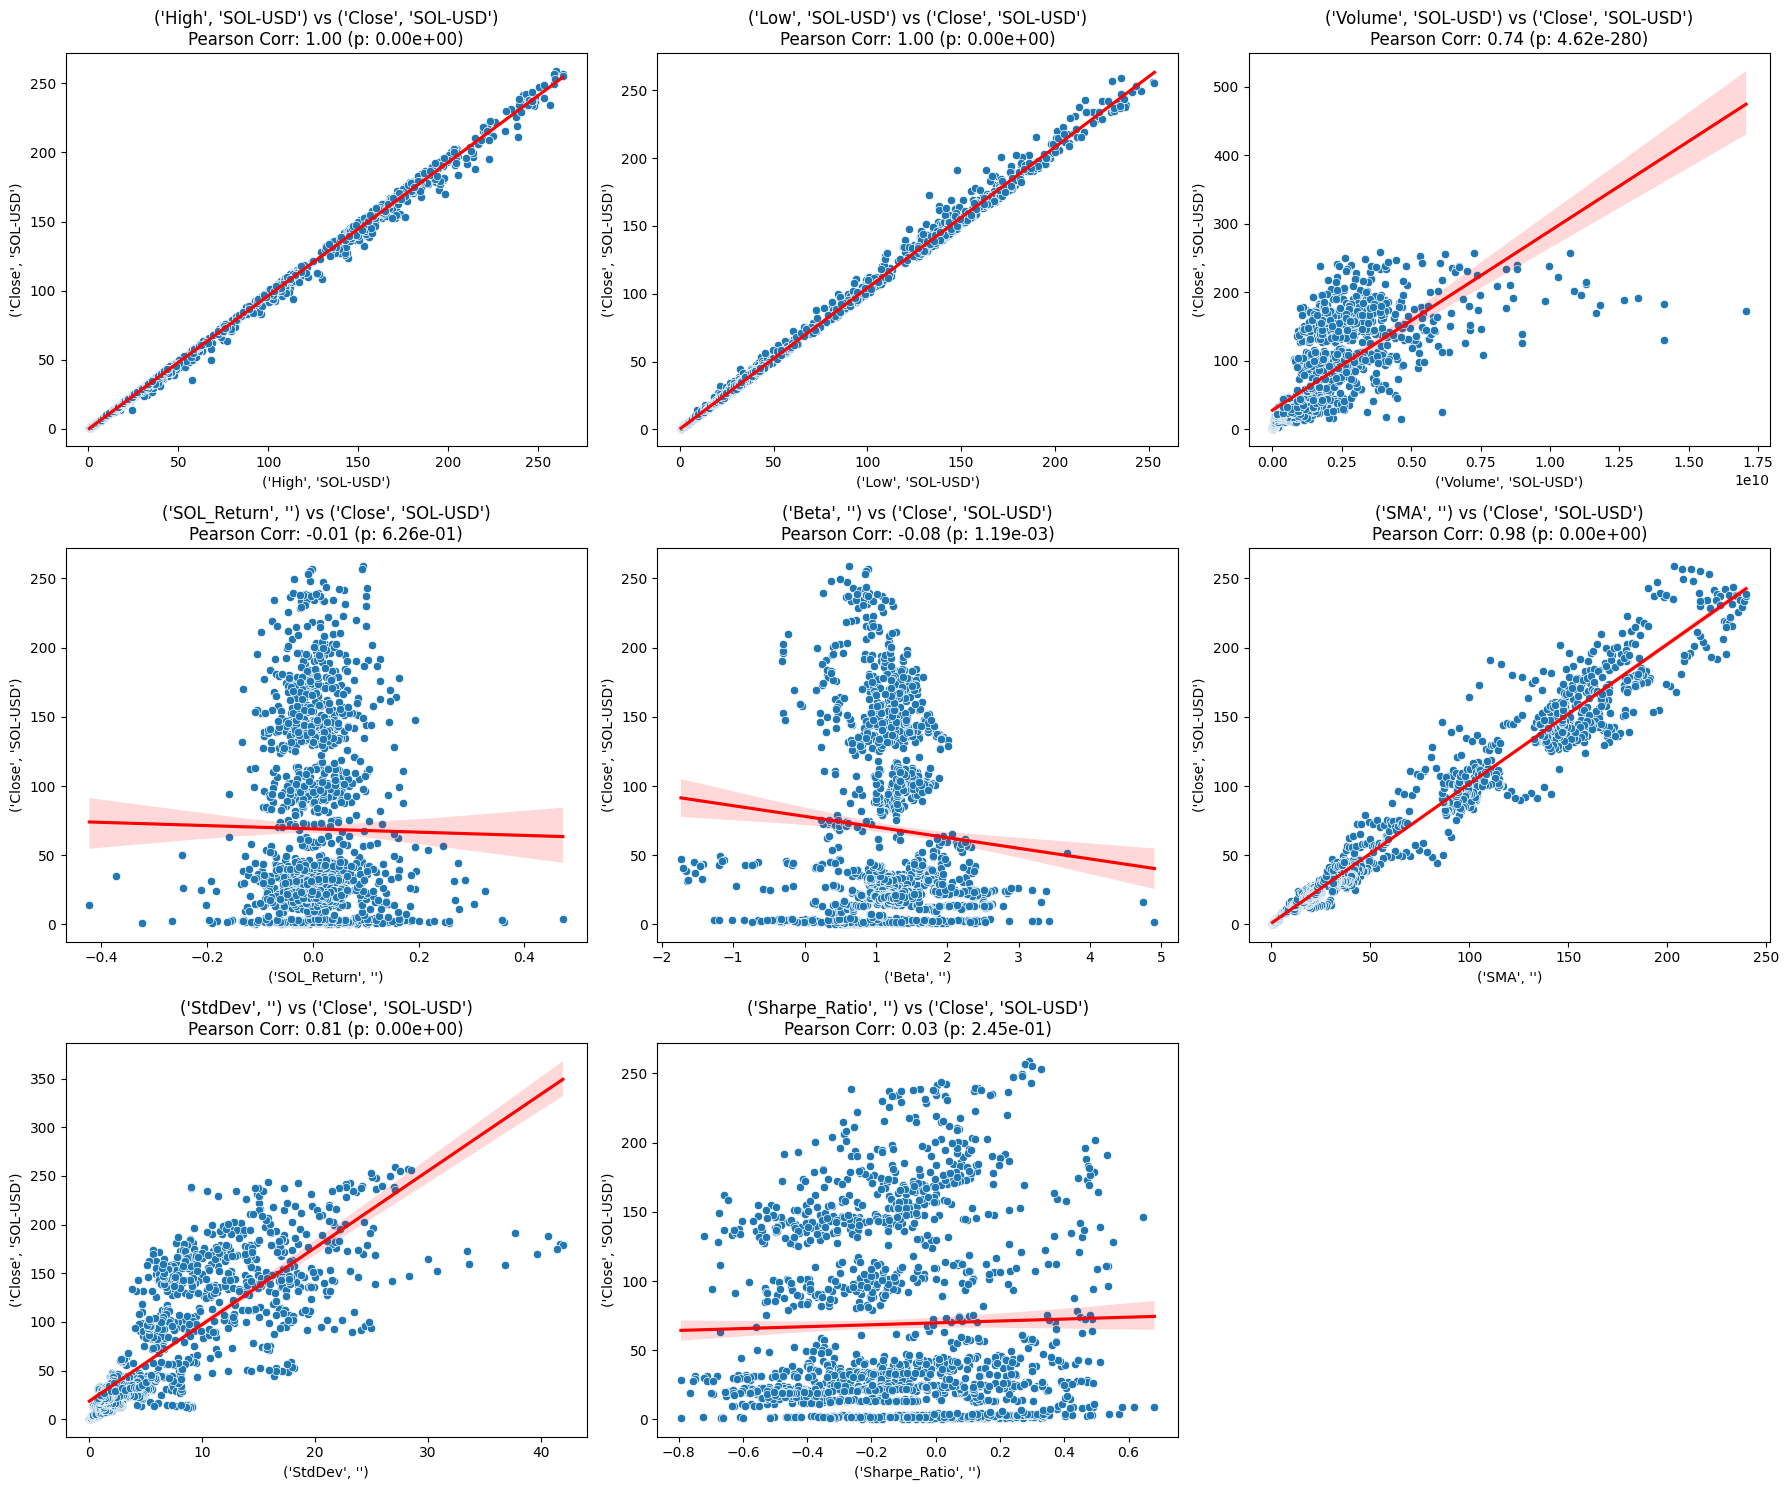

In [328]:
# Variabile dipendente
dependent_var = ('Close', 'SOL-USD')

# Lista delle variabili indipendenti (con MultiIndex)
independent_vars = [

    ('High', 'SOL-USD'),
    ('Low', 'SOL-USD'),
    ('Volume', 'SOL-USD'),
    ('SOL_Return', ''),
    ('Beta', ''),
    ('SMA', ''),
    ('StdDev', ''),
    ('Sharpe_Ratio', '')
]

# Filtra le variabili disponibili
available_vars = [var for var in independent_vars if var in df.columns]

# Rimuovi righe con NaN nelle variabili di interesse
df_filtered = df.dropna(subset=[dependent_var] + available_vars)

# Configurazione della griglia dei grafici
n_cols = 3  # Numero di colonne nella griglia
n_rows = -(-len(available_vars) // n_cols)  # Numero di righe necessario (ceil)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

# Scatter plot e analisi di linearità
for i, var in enumerate(available_vars):
    ax = axes[i]
    sns.scatterplot(x=df_filtered[var], y=df_filtered[dependent_var], ax=ax)
    sns.regplot(x=df_filtered[var], y=df_filtered[dependent_var], scatter=False, color='red', ax=ax)

    # Calcolo del coefficiente di correlazione
    corr, p_value = pearsonr(df_filtered[var], df_filtered[dependent_var])
    ax.set_title(f"{var} vs {dependent_var}\nPearson Corr: {corr:.2f} (p: {p_value:.2e})")
    ax.set_xlabel(var)
    ax.set_ylabel(dependent_var)

# Nascondi assi vuoti nella griglia
for j in range(len(available_vars), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [329]:
# modifico il dataframe con le nuove covariate

# Rimuoviamo le colonne specificate dal DataFrame
columns_to_drop = [('SOL_Adj_Close', 'SOL-USD'), ('Open', 'SOL-USD'), ('Upper_Band', ''), ('Lower_Band', '')]

# Creazione del nuovo DataFrame
df = df.drop(columns=columns_to_drop)
df.head()

Price,Close,High,Low,Volume,SOL_Return,Beta,SMA,StdDev,Sharpe_Ratio
Ticker,SOL-USD,SOL-USD,SOL-USD,SOL-USD,,,,,
Date,,,,,,,,,
2020-06-07,0.616578,0.624444,0.593398,716785,-0.009423,0.427358,0.595371,0.027581,-0.201951
2020-06-08,0.668313,0.679001,0.613310,1440234,0.083907,0.428930,0.597564,0.031483,-0.085599
2020-06-09,0.658002,0.668088,0.627242,988327,-0.015428,0.346123,0.601506,0.033900,-0.038440
2020-06-10,0.644867,0.670043,0.633404,1096203,-0.019962,0.524364,0.603304,0.035240,-0.103663
2020-06-11,0.573742,0.650535,0.570082,1122221,-0.110294,0.739265,0.600047,0.034787,-0.229623


**<h1>Pytorch Dataset</h1>**

### Description of the Code below

This code demonstrates how to preprocess a dataset stored in a Pandas DataFrame and transform it into a format suitable for use with PyTorch, while ensuring the data can be efficiently loaded in batches for training or inference.

1. **Feature and Target Definition**:
   - The column `Close` is chosen as the target variable (`y`), representing the Solana price.
   - The remaining columns are used as the feature set (`X`).

2. **Feature Normalization**:
   - The features are scaled using `StandardScaler` from `sklearn` to ensure they have zero mean and unit variance. This helps improve the stability and convergence of training neural networks.

3. **Conversion to PyTorch Tensors**:
   - The normalized features (`X`) are converted into a PyTorch tensor of type `torch.float32`.
   - The target (`y`) is similarly converted into a tensor, reshaped to have a shape of `(-1, 1)` to align with PyTorch's supervised learning expectations.

4. **Custom DataLoader Function**:
   - A function, `load_array`, is defined to create a PyTorch `DataLoader`. This function:
     - Accepts `data_arrays` (a tuple of feature and target tensors).
     - Uses unpacking (`*data_arrays`) to pass the tensors dynamically to `TensorDataset`.
     - Returns a `DataLoader` with a specified batch size.
     - Includes the `is_train` parameter to control whether data shuffling is enabled. Here, it defaults to `False` to maintain the historical order of the data.

5. **Batch Loading**:
   - The tensors for features (`X_tensor`) and target (`y_tensor`) are packed into a tuple `data_arrays`.
   - A `DataLoader` is created with a batch size of 32, ensuring that the data is processed in manageable chunks.

This code is well-suited for historical data processing (e.g., time-series or financial data) where the order of data is important, thanks to the use of `shuffle=False`. The preprocessing ensures the dataset is ready for efficient model training or evaluation in PyTorch.

In [330]:
data = df.values
data_norm = scaler.fit_transform(data)

# Salva il numero di caratteristiche (colonne)
num_features = data.shape[1]

# Create sequences
sequence_length = 5
X_sequences = []
y_sequences = []

n = len(data_norm)

for i in range(n - sequence_length):
    X_seq = data_norm[i:i+sequence_length]
    y_seq = data_norm[i + sequence_length][0]
    X_sequences.append(X_seq)
    y_sequences.append(y_seq)

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

X_tensor = torch.tensor(X_sequences, dtype=torch.float32)
y_tensor = torch.tensor(y_sequences, dtype=torch.float32).unsqueeze(-1)

In [331]:
# Suddivisione in training e validation set
n = len(X_sequences)
train_split = int(n * 0.7)  # Prime 70% osservazioni per il training
val_split = int(n * 0.9)    # Successive 20% osservazioni per la validation
test_split = n              # Ultime 10% osservazioni per il test

train_dataset = (X_tensor[:train_split], y_tensor[:train_split])
val_dataset = (X_tensor[train_split:val_split], y_tensor[train_split:val_split])
test_dataset = (X_tensor[val_split:test_split], y_tensor[val_split:test_split])

In [332]:
# Define a function for loading data with unpacking
def load_array(data_arrays, batch_size, is_train=False): # False because we want to read the data historically
    """Construct a PyTorch DataLoader."""
    dataset = TensorDataset(*data_arrays)  # Unpacking the tensors
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train)

# Create the DataLoader
batch_size = 32
train_loader = load_array(train_dataset, batch_size, is_train=True)
valid_loader = load_array(val_dataset, batch_size)
test_loader = load_array(test_dataset, batch_size)

In [333]:
batch_X, batch_y = next(iter(train_loader))
print(batch_X.shape)  # Expected: torch.Size([32, 10, 12])
print(batch_y.shape)

torch.Size([32, 5, 9])
torch.Size([32, 1])


# Baseline Naive Bayes

# LSTM

In [334]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.dropout = dropout

        self.lstm1 = nn.LSTM(input_size, hidden_size, 1, batch_first=True)
        # Dropout layer
        self.dropout_layer = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, 1, batch_first=True)
        # Layer fully connected
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Stato nascosto iniziale e stato della cella per il primo strato
        h0_1 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0_1 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Passaggio attraverso il primo strato LSTM
        out, _ = self.lstm1(x, (h0_1, c0_1))

        # Passaggio attraverso il livello di dropout
        out = self.dropout_layer(out)

        h0_2 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0_2 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm2(out, (h0_2, c0_2))

        # Passaggio attraverso il layer fully connected
        out = self.fc(out[:, -1, :])
        return out


In [335]:
# Iperparametri
input_size = 9
hidden_size = 100
output_size = 1
learning_rate = 0.001
num_epochs = 200
dropout = 0.2

# Inizializzazione del modello, della loss function e dell'optimizer
model = LSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss() #vedere se esiste il mae
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping
best_loss = float('inf')
epochs_no_improve = 0
early_stop = False
best_model_state = None

To update the model weights at the epoch with the best validation loss (instead of the epoch where early stopping is triggered, typically 5 epochs later), we utilized PyTorch’s state_dict. The state_dict is a Python dictionary that maps each layer of the model to its corresponding parameter tensors (such as weights and biases). By saving the model's state at the best epoch and restoring it later, we ensured that the model uses the optimal weights at the end of training.

In PyTorch, the model parameters (weights and biases) can be accessed using model.parameters(), while the state_dict allows for advanced state management. Only layers with learnable parameters (e.g., convolutional and linear layers) or registered buffers (e.g., running_mean in BatchNorm) are included in the state_dict. Optimizer objects (torch.optim) also have a state_dict, which stores both the optimizer state and the hyperparameters used.

In [336]:
# Liste per salvare le metriche
train_losses = []
val_losses = []
train_mae = []
val_mae = []
epochs = []

model.train()

for epoch in range(num_epochs):
    if early_stop:
        print(f"Early stopping at epoch {epoch}. Best epoch: {best_epoch} with best val loss {best_loss}")
        model.load_state_dict(best_model_state)
        break

    model.train()
    train_loss = 0.0
    train_actuals = []
    train_predictions = []

    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass e aggiornamento dei pesi
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Salva predizioni e target per calcolo delle metriche
        train_actuals.extend(batch_y.numpy())
        train_predictions.extend(outputs.detach().numpy())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)  # Salva la loss di training

    # Calcola metriche di training
    train_mae.append(mean_absolute_error(train_actuals, train_predictions))

    # Validation
    model.eval()
    val_loss = 0.0
    val_actuals = []
    val_predictions = []

    with torch.no_grad():
        for val_X, val_y in valid_loader:
            val_outputs = model(val_X)
            loss = criterion(val_outputs, val_y)
            val_loss += loss.item()

            # Salva predizioni e target per calcolo delle metriche
            val_actuals.extend(val_y.numpy())
            val_predictions.extend(val_outputs.numpy())

    val_loss /= len(valid_loader)
    val_losses.append(val_loss)  # Salva la loss di validazione

    # Calcola metriche di validazione
    val_mae.append(mean_absolute_error(val_actuals, val_predictions))

    epochs.append(epoch + 1)  # Salva l'epoca corrente

    # Stampa della loss e delle metriche ogni 10 epoche
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train MAE: {train_mae[-1]:.4f}, Val MAE: {val_mae[-1]:.4f},")

    # Early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        best_epoch = epoch + 1
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= 5:
        early_stop = True

Epoch [1/200], Train Loss: 0.0329, Val Loss: 0.0055, Train MAE: 0.1199, Val MAE: 0.0663,
Epoch [2/200], Train Loss: 0.0020, Val Loss: 0.0018, Train MAE: 0.0308, Val MAE: 0.0322,
Epoch [3/200], Train Loss: 0.0014, Val Loss: 0.0014, Train MAE: 0.0234, Val MAE: 0.0253,
Epoch [4/200], Train Loss: 0.0014, Val Loss: 0.0017, Train MAE: 0.0235, Val MAE: 0.0330,
Epoch [5/200], Train Loss: 0.0013, Val Loss: 0.0014, Train MAE: 0.0230, Val MAE: 0.0276,
Epoch [6/200], Train Loss: 0.0011, Val Loss: 0.0011, Train MAE: 0.0197, Val MAE: 0.0238,
Epoch [7/200], Train Loss: 0.0010, Val Loss: 0.0010, Train MAE: 0.0190, Val MAE: 0.0235,
Epoch [8/200], Train Loss: 0.0011, Val Loss: 0.0010, Train MAE: 0.0207, Val MAE: 0.0216,
Epoch [9/200], Train Loss: 0.0009, Val Loss: 0.0011, Train MAE: 0.0180, Val MAE: 0.0245,
Epoch [10/200], Train Loss: 0.0009, Val Loss: 0.0008, Train MAE: 0.0180, Val MAE: 0.0205,
Epoch [11/200], Train Loss: 0.0010, Val Loss: 0.0009, Train MAE: 0.0192, Val MAE: 0.0224,
Epoch [12/200], Tra

In [337]:
# Save the best model
if best_model_state is not None:
    save_path = "best_model.pth"
    torch.save(best_model_state, save_path)
    print(f"Best model saved to {save_path}")

Best model saved to best_model.pth


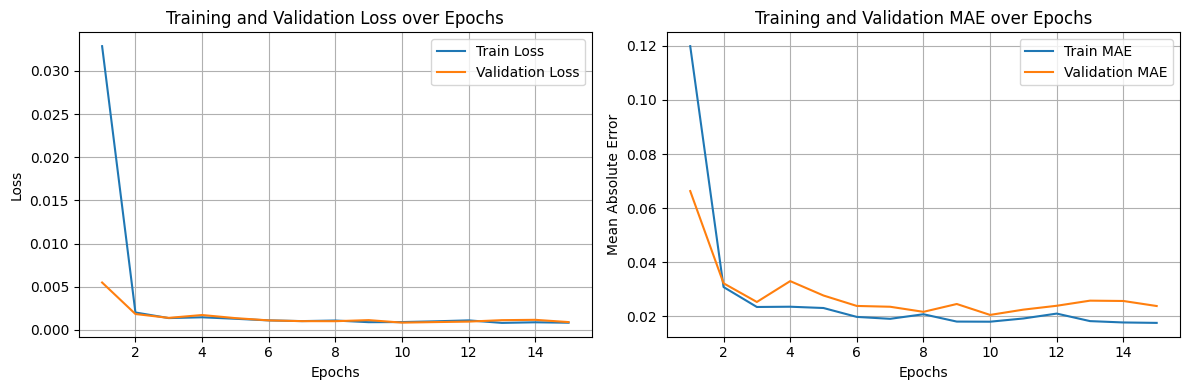

In [338]:
# Visualizzazione delle metriche
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axs[0].plot(epochs, train_losses, label='Train Loss')
axs[0].plot(epochs, val_losses, label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].legend()
axs[0].grid()

# MAE plot
axs[1].plot(epochs, train_mae, label='Train MAE')
axs[1].plot(epochs, val_mae, label='Validation MAE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Mean Absolute Error')
axs[1].set_title('Training and Validation MAE over Epochs')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

1. Convergenza graduale:
- La training loss e la validation loss diminuiscono costantemente durante le epoche, indicando che il modello sta imparando correttamente dai dati.
- Questo è un segnale positivo, in quanto indica che il modello non presenta comportamenti anomali o problemi nell'ottimizzazione iniziale.

2. No overfitting evidente:

- La validation loss segue un trend simile alla training loss senza un incremento significativo, anche dopo molte epoche. Questo suggerisce che il modello non sta sovradattando i dati di training.
- Tuttavia, alla fine del grafico, la validation loss sembra stabilizzarsi leggermente sopra la training loss, un comportamento previsto poiché i dati di validazione sono separati.

3. Early Stopping ben configurato:

- L'addestramento si è fermato dopo circa 130-140 epoche, quando le performance hanno smesso di migliorare. Questo è utile per evitare di continuare l'addestramento inutilmente, risparmiando tempo e risorse.

4. Differenza tra training e validation loss:

- Anche se la validation loss è superiore alla training loss (un comportamento normale), il gap tra i due valori sembra essere costante. Questo suggerisce che il modello generalizza bene.

In [339]:
# Esamina il test set
model.eval()
test_predictions = []
test_actuals = []

model.eval()

with torch.no_grad():
    for test_X, test_y in test_loader:
        outputs = model(test_X)
        test_predictions.extend(outputs.numpy())
        test_actuals.extend(test_y.numpy())

In [340]:
def denormalization(pred, test_actuals, num_features):

  pred = np.array(pred).reshape(-1, 1)
  test_predictions_expanded = np.zeros((pred.shape[0], num_features))
  test_predictions_expanded[:, 0] = pred[:, 0]  # Inserisci i dati nella prima colonna
  pred = scaler.inverse_transform(test_predictions_expanded)
  pred = pred[:, 0]

  test_actuals = np.array(test_actuals).reshape(-1, 1)
  test_actuals_expanded = np.zeros((test_actuals.shape[0], num_features))
  test_actuals_expanded[:, 0] = test_actuals[:, 0]
  test_actuals_denorm = scaler.inverse_transform(test_actuals_expanded)
  test_actuals_denorm = test_actuals_denorm[:, 0]
  return pred, test_actuals_denorm

test_predictions, test_actuals = denormalization(test_predictions, test_actuals, num_features)

In [341]:
# Output delle performance
stop = 0
print("Predizioni vs Valori Reali")
for i, j  in zip(test_predictions, test_actuals):
  print(f"{round(i, 2)} $      {round(j, 2)} $")
  stop += 1
  if stop == 10:
    break

Predizioni vs Valori Reali
129.11 $      149.45 $
133.71 $      139.7 $
137.18 $      140.01 $
138.63 $      146.49 $
140.05 $      146.6 $
141.97 $      153.7 $
144.19 $      140.73 $
145.41 $      127.55 $
143.15 $      134.37 $
140.91 $      143.24 $


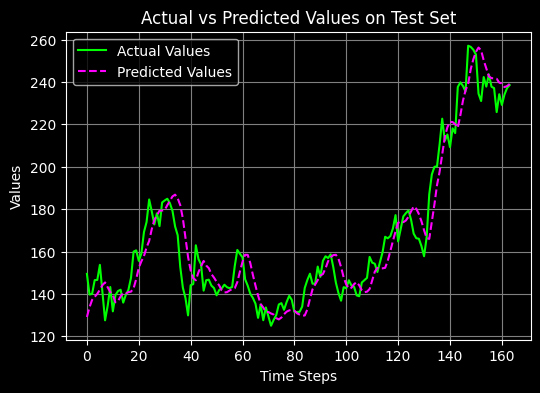

In [342]:
# Visualizzazione delle performance
plt.style.use('dark_background')
plt.figure(figsize=(6, 4))
plt.plot(test_actuals, label='Actual Values', color='lime')
plt.plot(test_predictions, label='Predicted Values', color='fuchsia', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(color='gray')
plt.show()

Il formato del tensore torch.Size([32, 12]) che ottieni con next(iter(data_loader))[0].shape è parzialmente corretto per creare una LSTM, ma manca una dimensione fondamentale: la dimensione di sequenza temporale.

Per una LSTM, il tensore di input dovrebbe avere la seguente forma:

(
batch_size
,
sequence_length
,
input_size
)
(batch_size,sequence_length,input_size)

Spesso la scelta di sequence_length viene fatta sperimentalmente:

Prova diversi valori (ad esempio, 1, 5, 7) e confronta le prestazioni del modello (ad esempio, tramite metriche come MSE o MAE).
Usa la validazione incrociata per capire quale valore produce le previsioni più accurate.
